In [1]:
from pc import PS
from modules import ADC,DAC,CHIP
from cimCommand import CMD,CmdData,Packet
from cimCommand.singleCmdInfo import *

In [2]:
# 用于和下位机交互通信
ps=PS("192.168.1.10", 7,delay=0.3,debug=False)

Connected to 192.168.1.10:7
local ip: 192.168.1.15 local port: 58324


In [4]:
# 控制ADC
adc=ADC(ps)
# 控制DAC
dac=DAC(ps)
# 芯片，读写操作，device_cfg
chip=CHIP(adc,dac,ps)

In [65]:
ps.close()

Connection closed.


In [42]:
adc.set_gain(3)

------------------------------ 发送指令: ------------------------------ 
模式：1,指令：gain
字节码：55 aa 01 10 00 00 00 03

------------------------------ 指令发送完成！------------------------------ 



In [38]:
chip.set_device_cfg(deviceType=1)

------------------------------ 发送指令: ------------------------------ 
模式：1,指令：device_cfg
字节码：55 aa 01 07 00 00 07 fd

------------------------------ 指令发送完成！------------------------------ 



In [39]:

def adc_to_voltage(data, vref=1.25):
    # 将十六进制字符串转换为整数
    data = int(data, 16)
    # 确保数据在16位范围内
    data &= 0xFFFF
    # 将16位有符号数转换为Python整数
    if data & 0x8000:  # 若符号位为1，则表示负数
        data -= 0x10000

    # 将数据转换为电压
    voltage = (data / (2**15-1)) * vref  # 32767 是0x7FFF对应的正最大值
    return voltage

In [165]:
# ps.delay = 0.3
ps.debug = True

In [51]:
pkts=Packet()
pkts.append_cmdlist([
    CMD(FLT,command_data=CmdData(0x0FFF)),                      # 配置flt
],mode=1)

# 发送指令
ps.send_packets(pkts)

------------------------------ 发送指令: ------------------------------ 
模式：1,指令：flt
字节码：55 aa 01 09 00 00 0f ff

------------------------------ 指令发送完成！------------------------------ 



In [128]:
def get_data(num:list):
    bank,index = 0,0
    for i in num:
        bank_tmp,index_tmp = chip.numToBank_Index(i)
        bank = bank | (1<<bank_tmp)
        index = index | (1<<index_tmp)
    return bank,index

In [130]:
colnum=[i*32 for i in range(8)]+[i*32+1 for i in range(8)]

print(colnum)

[0, 32, 64, 96, 128, 160, 192, 224, 1, 33, 65, 97, 129, 161, 193, 225]


In [2]:
# 配置行列的latch
rownum=[[23]]
colnum=[[97]]
# colnum=[[0,32], [64,96], [128,160], [192,224], [1,33], [65,97], [129,161], [193,225]]
pkts=Packet()
pkts.append_cmdlist([CMD(CIM_RESET,command_data=CmdData(1))],mode=1)                 # reset指令
ps.send_packets(pkts)

# 配置行
for i in rownum:
    xbank,xindex = get_data(i)
    pkts=Packet()
    pkts.append_cmdlist([
        # 行reg配置
        CMD(CIM_DATA_IN,command_data=CmdData(xindex)),       # 第xindex位置1
        CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_cim_data_in)),       # cfg_cim_data_in
        CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_reg_clk)),           # cfg_reg_clk

        # 行bank配置
        CMD(ROW_COL_SEL,command_data=CmdData(1)),               # 设置为行模式
        CMD(CIM_BANK_SEL,command_data=CmdData(xbank)),       # 行bank选择
        CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_bank_sel)),          # cfg_bank_sel
        CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_latch_clk)),         # cfg_latch_clk
    ],mode=1)
    ps.send_packets(pkts)

# 配置列
for i in colnum:
    ybank,yindex = get_data(i)
    
    pkts=Packet()
    pkts.append_cmdlist([
        # 列reg配置
        CMD(CIM_DATA_IN,command_data=CmdData(yindex)),       # 第yindex位置1
        CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_cim_data_in)),       # cfg_cim_data_in
        CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_reg_clk)),           # cfg_reg_clk

        # 列bank配置
        CMD(ROW_COL_SEL,command_data=CmdData(0)),               # 设置为列模式
        CMD(CIM_BANK_SEL,command_data=CmdData(ybank)),       # 列bank选择
        CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_bank_sel)),          # cfg_bank_sel
        CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_latch_clk)),         # cfg_latch_clk
    ],mode=1)
    ps.send_packets(pkts)

# 设置为read模式
pkts=Packet()
pkts.append_cmdlist([
    CMD(ROW_CTRL,command_data=CmdData(1)),                  # 配置行到施加电压
    CMD(COL_CTRL,command_data=CmdData(1)),                  # 配置列到TIA  
])
ps.send_packets(pkts)

# dac.set_voltage(0,dac_num=0,dac_channel=0)           # ROW_Va电压
# dac.set_voltage(0,dac_num=0,dac_channel=1)           # ROW_Va电压
# dac.set_voltage(0,dac_num=0,dac_channel=2)           # ROW_Va电压
# dac.set_voltage(0,dac_num=0,dac_channel=3)           # ROW_Va电压

v = 0.4
dac.set_voltage(v,dac_num=0,dac_channel=4)           # ROW_Va电压
dac.set_voltage(v,dac_num=0,dac_channel=5)           # ROW_Va电压
dac.set_voltage(v,dac_num=0,dac_channel=6)           # ROW_Va电压
dac.set_voltage(v,dac_num=0,dac_channel=7)           # ROW_Va电压


dac.set_voltage(v,dac_num=1,dac_channel=0)           # ROW_Va电压
dac.set_voltage(v,dac_num=1,dac_channel=1)           # ROW_Va电压
dac.set_voltage(v,dac_num=1,dac_channel=2)           # ROW_Va电压
dac.set_voltage(v,dac_num=1,dac_channel=3)           # ROW_Va电压

# 设置PCB的TIA，为列
pkts=Packet()
pkts.append_cmdlist([CMD(ROW_COL_SW,command_data=CmdData(1)),],mode=1)

# 发送指令
ps.send_packets(pkts)

# # 设置ADC采样点数
# chip.adc.set_sample_times(32)

pkts=Packet()
pkts.append_cmdlist([
    CMD(PULSE_CYC,command_data=CmdData(0)),                                                 # 翻转
    CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_col_pulse)),             # cfg_col_pulse，配置列为常1
    CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_row_read)),              # 然后开始读
    CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_col_pulse)),             # cfg_col_pulse，读完后，把列电压翻转为0
],mode=1)
chip.ps.send_packets(pkts)


NameError: name 'Packet' is not defined

In [144]:
vres = []
cond_res = []
for i in colnum:
    for j in i:
        TIA_num = adc.TIA_index_map(j,1,True)
        adc_num, adc_channel = int(TIA_num/4),TIA_num%4

        channel_map = {0: 'A', 1: 'B', 2: 'C', 3: 'D'}
        pkts=Packet()
        adc_out = CMD(dict(
            command_addr = 65+TIA_num,
            command_type = COMMAND_TYPE[1],
            n_addr_bytes = N_ADDR_BYTES[0],
            n_data_bytes = N_DATA_BYTES[0],
            command_name = f"adc{adc_num}_out{channel_map[adc_channel]}",
            command_data = CmdData(0),
            command_description = "从ADC对应通道读取数据"
        ))
        pkts.append_cmdlist([adc_out],mode=2)
        print("DAC:",f"adc{adc_num}_out{channel_map[adc_channel]}")
        # 发送指令
        ps.send_packets(pkts)
        # 接收信息
        # 高16bit：0，低16bit：寄存器的16bit值
        message = ps.receive_packet(f"adc读取:{adc_out.command_name}")

        voltage_sample_hex = message.hex()[2:4] + message.hex()[0:2]
        # print("电压hex: ",voltage_sample_hex)
        voltage_sample_int = adc_to_voltage(voltage_sample_hex)
        vres.append(voltage_sample_int)
        print("电压int: ",voltage_sample_int)
        res_meas = 0.1 * (10e3+200) * 6.0241 / (voltage_sample_int+1e-10)
        cond_res.append(res_meas)
    # print(res_meas)

DAC: adc3_outD
---Received---
b'\x85\x11\x00\x00'

电压int:  0.17109439374980925


In [147]:
vres2 = []
cond_res2 = []
for i in colnum:
    TIA_num = adc.TIA_index_map(i[0],1,True)
    adc_num, adc_channel = int(TIA_num/4),TIA_num%4

    channel_map = {0: 'A', 1: 'B', 2: 'C', 3: 'D'}
    pkts=Packet()
    adc_out = CMD(dict(
        command_addr = 65+TIA_num,
        command_type = COMMAND_TYPE[1],
        n_addr_bytes = N_ADDR_BYTES[0],
        n_data_bytes = N_DATA_BYTES[0],
        command_name = f"adc{adc_num}_out{channel_map[adc_channel]}",
        command_data = CmdData(0),
        command_description = "从ADC对应通道读取数据"
    ))
    pkts.append_cmdlist([adc_out],mode=2)
    print("DAC:",f"adc{adc_num}_out{channel_map[adc_channel]}")
    # 发送指令
    ps.send_packets(pkts)
    # 接收信息
    # 高16bit：0，低16bit：寄存器的16bit值
    message = ps.receive_packet(f"adc读取:{adc_out.command_name}")

    voltage_sample_hex = message.hex()[2:4] + message.hex()[0:2]
    # print("电压hex: ",voltage_sample_hex)
    voltage_sample_int = adc_to_voltage(voltage_sample_hex)
    vres2.append(voltage_sample_int)
    print("电压int: ",voltage_sample_int)
    res_meas = 0.1 * (10e3+200) * 6.0241 / voltage_sample_int
    cond_res2.append(res_meas)
    # print(res_meas)

DAC: adc3_outD
---Received---
b'\x87\x11\x00\x00'

电压int:  0.17117069002349924


In [150]:
vres3 = []
cond_res3 = []
for i in colnum:
    for j in i:
        TIA_num = adc.TIA_index_map(j,1,True)
        adc_num, adc_channel = int(TIA_num/4),TIA_num%4

        channel_map = {0: 'A', 1: 'B', 2: 'C', 3: 'D'}
        pkts=Packet()
        adc_out = CMD(dict(
            command_addr = 65+TIA_num,
            command_type = COMMAND_TYPE[1],
            n_addr_bytes = N_ADDR_BYTES[0],
            n_data_bytes = N_DATA_BYTES[0],
            command_name = f"adc{adc_num}_out{channel_map[adc_channel]}",
            command_data = CmdData(0),
            command_description = "从ADC对应通道读取数据"
        ))
        pkts.append_cmdlist([adc_out],mode=2)
        print("DAC:",f"adc{adc_num}_out{channel_map[adc_channel]}")
        # 发送指令
        ps.send_packets(pkts)
        # 接收信息
        # 高16bit：0，低16bit：寄存器的16bit值
        message = ps.receive_packet(f"adc读取:{adc_out.command_name}")

        voltage_sample_hex = message.hex()[2:4] + message.hex()[0:2]
        # print("电压hex: ",voltage_sample_hex)
        voltage_sample_int = adc_to_voltage(voltage_sample_hex)
        vres3.append(voltage_sample_int)
        print("电压int: ",voltage_sample_int)
        res_meas = 0.1 * (10e3+200) * 6.0241 / (voltage_sample_int+1e-10)
        cond_res3.append(res_meas)
    # print(res_meas)

DAC: adc3_outD
---Received---
b'\x89\x11\x00\x00'

电压int:  0.17124698629718924


In [154]:
vres4 = []
cond_res4 = []
for i in colnum:
    for j in i:
        TIA_num = adc.TIA_index_map(j,1,True)
        adc_num, adc_channel = int(TIA_num/4),TIA_num%4

        channel_map = {0: 'A', 1: 'B', 2: 'C', 3: 'D'}
        pkts=Packet()
        adc_out = CMD(dict(
            command_addr = 65+TIA_num,
            command_type = COMMAND_TYPE[1],
            n_addr_bytes = N_ADDR_BYTES[0],
            n_data_bytes = N_DATA_BYTES[0],
            command_name = f"adc{adc_num}_out{channel_map[adc_channel]}",
            command_data = CmdData(0),
            command_description = "从ADC对应通道读取数据"
        ))
        pkts.append_cmdlist([adc_out],mode=2)
        print("DAC:",f"adc{adc_num}_out{channel_map[adc_channel]}")
        # 发送指令
        ps.send_packets(pkts)
        # 接收信息
        # 高16bit：0，低16bit：寄存器的16bit值
        message = ps.receive_packet(f"adc读取:{adc_out.command_name}")

        voltage_sample_hex = message.hex()[2:4] + message.hex()[0:2]
        # print("电压hex: ",voltage_sample_hex)
        voltage_sample_int = adc_to_voltage(voltage_sample_hex)
        vres4.append(voltage_sample_int)
        print("电压int: ",voltage_sample_int)
        res_meas = 0.1 * (10e3+200) * 6.0241 / (voltage_sample_int+1e-10)
        cond_res4.append(res_meas)
    # print(res_meas)

DAC: adc3_outD
---Received---
b'W\x11\x00\x00'

电压int:  0.16933957945493944


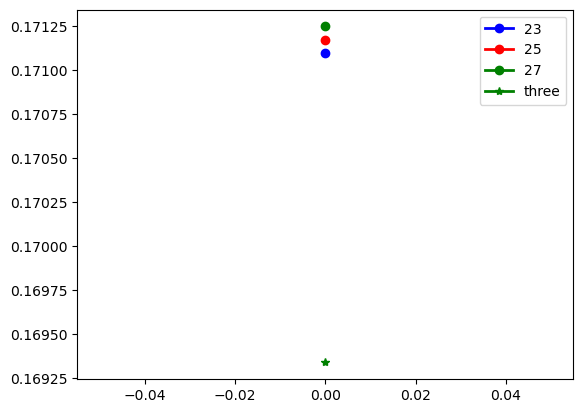

In [157]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot( vres, marker='o', color='b', linestyle='-', linewidth=2, markersize=6,label = "23")
plt.plot( vres2, marker='o', color='r', linestyle='-', linewidth=2, markersize=6,label = "25")
plt.plot( vres3, marker='o', color='g', linestyle='-', linewidth=2, markersize=6,label = "27")

plt.plot( vres4, marker='*', color='g', linestyle='-', linewidth=2, markersize=6,label = "three")
plt.legend()
plt.show()

DAC: adc0_outA
------------------------------ 发送指令: ------------------------------ 
模式：2,指令：adc0_outA
字节码：55 aa 02 41

------------------------------ 指令发送完成！------------------------------ 

---Received---
b'h\x00\x00\x00'

电压int:  0.003967406231879635
DAC: adc0_outB
------------------------------ 发送指令: ------------------------------ 
模式：2,指令：adc0_outB
字节码：55 aa 02 42

------------------------------ 指令发送完成！------------------------------ 

---Received---
b'\xa1\xfe\xff\xff'

电压int:  -0.01338999603259377
DAC: adc0_outC
------------------------------ 发送指令: ------------------------------ 
模式：2,指令：adc0_outC
字节码：55 aa 02 43

------------------------------ 指令发送完成！------------------------------ 

---Received---
b'\xa4\x00\x00\x00'

电压int:  0.006256294442579424
DAC: adc0_outD
------------------------------ 发送指令: ------------------------------ 
模式：2,指令：adc0_outD
字节码：55 aa 02 44

------------------------------ 指令发送完成！------------------------------ 

---Received---
b'\xbd\x00\x00\x00'

电压int:  0.00

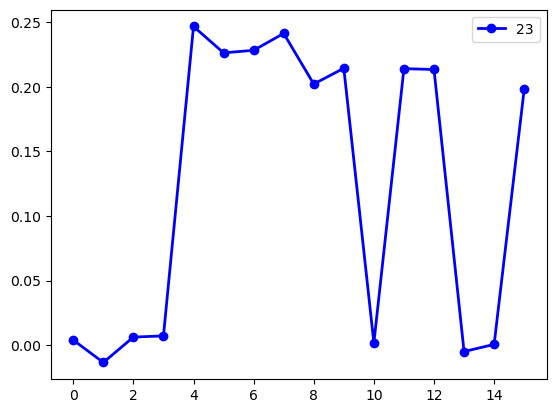

In [179]:
# pkts=Packet()
# pkts.append_cmdlist([CMD(CIM_RESET,command_data=CmdData(1))],mode=1)                 # reset指令
# ps.send_packets(pkts)

# pkts=Packet()
# pkts.append_cmdlist([
#     CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_row_read)),              # 然后开始读
# ],mode=1)
# ps.send_packets(pkts)

tia16 = []
for TIA_num in range(16):
    adc_num, adc_channel = int(TIA_num/4),TIA_num%4

    channel_map = {0: 'A', 1: 'B', 2: 'C', 3: 'D'}
    pkts=Packet()
    adc_out = CMD(dict(
        command_addr = 65+TIA_num,
        command_type = COMMAND_TYPE[1],
        n_addr_bytes = N_ADDR_BYTES[0],
        n_data_bytes = N_DATA_BYTES[0],
        command_name = f"adc{adc_num}_out{channel_map[adc_channel]}",
        command_data = CmdData(0),
        command_description = "从ADC对应通道读取数据"
    ))
    pkts.append_cmdlist([adc_out],mode=2)
    print("DAC:",f"adc{adc_num}_out{channel_map[adc_channel]}")
    # 发送指令
    ps.send_packets(pkts)
    # 接收信息
    # 高16bit：0，低16bit：寄存器的16bit值
    message = ps.receive_packet(f"adc读取:{adc_out.command_name}")

    voltage_sample_hex = message.hex()[2:4] + message.hex()[0:2]
    # print("电压hex: ",voltage_sample_hex)
    voltage_sample_int = adc_to_voltage(voltage_sample_hex)
    tia16.append(voltage_sample_int)
    print("电压int: ",voltage_sample_int)

plt.figure()
plt.plot( tia16, marker='o', color='b', linestyle='-', linewidth=2, markersize=6,label = "23")
plt.legend()
plt.show()

In [ ]:
# 31，0.319
# 33，0.3185
# 35，0.318

In [19]:
res_meas = 0.1 * (200) * 1 / voltage_sample_int
print(res_meas)
print(1/res_meas*1e6)

53.88201438848921
18559.068575090794


In [40]:
res_meas = 0.1 * (10e3+200) * 6.0241 / voltage_sample_int
print(res_meas)
# 0.11,

87681.88062885137


In [8]:
def adc_to_voltage(data, vref=1.25):
    # 将十六进制字符串转换为整数
    data = int(data, 16)
    # 确保数据在16位范围内
    data &= 0xFFFF
    # 将16位有符号数转换为Python整数
    if data & 0x8000:  # 若符号位为1，则表示负数
        data -= 0x10000

    # 将数据转换为电压
    voltage = (data / (2**15-1)) * vref  # 32767 是0x7FFF对应的正最大值
    return voltage

In [95]:
pkts=Packet()
pkts.append_cmdlist([
    CMD(CIM_RESET,command_data=CmdData(1)),                 # reset指令
],mode=1)
# 发送指令
ps.send_packets(pkts)

In [96]:

pkts=Packet()
pkts.append_cmdlist([
    CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_row_read)),              # 然后开始读
],mode=1)
chip.ps.send_packets(pkts)

TIA_num = adc.TIA_index_map(colnum,1,True)
adc_num, adc_channel = int(TIA_num/4),TIA_num%4

channel_map = {0: 'A', 1: 'B', 2: 'C', 3: 'D'}
pkts=Packet()
adc_out = CMD(dict(
    command_addr = 65+TIA_num,
    command_type = COMMAND_TYPE[1],
    n_addr_bytes = N_ADDR_BYTES[0],
    n_data_bytes = N_DATA_BYTES[0],
    command_name = f"adc{adc_num}_out{channel_map[adc_channel]}",
    command_data = CmdData(0),
    command_description = "从ADC对应通道读取数据"
))
pkts.append_cmdlist([adc_out],mode=2)

# 发送指令
ps.send_packets(pkts)
# 接收信息
# 高16bit：0，低16bit：寄存器的16bit值
message = ps.receive_packet(f"adc读取:{adc_out.command_name}")
voltage_sample_hex = message.hex()[2:4] + message.hex()[0:2]
print("电压hex: ",voltage_sample_hex)
voltage_sample_int = adc_to_voltage(voltage_sample_hex)
print("电压int: ",voltage_sample_int)

---Received---
b'i\x00\x00\x00'

电压hex:  0069
电压int:  0.004005554368724631


In [45]:
def adc_to_voltage(data, vref=1.25):
    # 将十六进制字符串转换为整数
    data = int(data, 16)
    # 确保数据在16位范围内
    data &= 0xFFFF
    # 将16位有符号数转换为Python整数
    if data & 0x8000:  # 若符号位为1，则表示负数
        data -= 0x10000

    # 将数据转换为电压
    voltage = (data / (2**15-1)) * vref  # 32767 是0x7FFF对应的正最大值
    return voltage

for i in range(16):
    print("读通道",i)
    TIA_num = i
    adc_num, adc_channel = int(TIA_num/4),TIA_num%4

    channel_map = {0: 'A', 1: 'B', 2: 'C', 3: 'D'}
    pkts=Packet()
    adc_out = CMD(dict(
        command_addr = 65+TIA_num,
        command_type = COMMAND_TYPE[1],
        n_addr_bytes = N_ADDR_BYTES[0],
        n_data_bytes = N_DATA_BYTES[0],
        command_name = f"adc{adc_num}_out{channel_map[adc_channel]}",
        command_data = CmdData(0),
        command_description = "从ADC对应通道读取数据"
    ))
    pkts.append_cmdlist([adc_out],mode=2)

    # 发送指令
    ps.send_packets(pkts)
    # 接收信息
    # 高16bit：0，低16bit：寄存器的16bit值
    message = ps.receive_packet(f"adc读取:{adc_out.command_name}")
    voltage_sample_hex = message.hex()[2:4] + message.hex()[0:2]
    print("电压hex: ",voltage_sample_hex)
    voltage_sample_int = adc_to_voltage(voltage_sample_hex)
    print("电压int: ",voltage_sample_int)

读通道 0
---Received---
b'\x95\x00\x00\x00'

电压hex:  0095
电压int:  0.005684072389904477
读通道 1
---Received---
b'\xf9\xe4\xff\xff'

电压hex:  e4f9
电压int:  -0.2639469588305307
读通道 2
---Received---
b'\xf5\x06\x00\x00'

电压hex:  06f5
电压int:  0.06794183172093875
读通道 3
---Received---
b'f,\x00\x00'

电压hex:  2c66
电压int:  0.4335917233802301
读通道 4
---Received---
b'\x9e\x11\x00\x00'

电压hex:  119e
电压int:  0.17204809717093417
读通道 5
---Received---
b'\xb4\xf3\xff\xff'

电压hex:  f3b4
电压int:  -0.12009033478804895
读通道 6
---Received---
b'\x88\x08\x00\x00'

电压hex:  0888
电压int:  0.08331553086947234
读通道 7
---Received---
b'\x0b\xfd\xff\xff'

电压hex:  fd0b
电压int:  -0.02887813959166234
读通道 8
---Received---
b'Y\xfc\xff\xff'

电压hex:  fc59
电压int:  -0.03566850795007172
读通道 9
---Received---
b'\xfd\xf5\xff\xff'

电压hex:  f5fd
电压int:  -0.097773674733726
读通道 10
---Received---
b'\n\xfc\xff\xff'

电压hex:  fc0a
电压int:  -0.038682210760826445
读通道 11
---Received---
b'\x16\x05\x00\x00'

电压hex:  0516
电压int:  0.049668874172185434
读通道 12
-

In [11]:
ps.set_debug(True)

# adc.set_sample_times(32)
# dac.set_voltage(5,0,0)
# chip.set_pulse_width(pulsewidth=255)
# chip.set_pulse_width(pulsewidth=1)